<img src="valorumdata.svg" height="100px" width="200px" style="float: right;"/>

# Pandas: merge
---

**Prerequisites**

- Reshape

**Outcomes**

- Know the different pandas routines for combining datasets
- Know when to use `pd.concat` vs `pd.merge` vs `pd.join`
- Be able to apply the three main combining routines

---
    


## Combining datasets

Often we will want perform joint analysis on data from different sources. 

For example, when analyzing the regional sales for a company we might want to bring in industry aggregates or demographic information for each region

Or perhaps we are working with product level data and have a list of product groups in a separate dataset and want to compute aggregate statistics for each group

In pandas there are three main methods for accomplishing these goals: `pd.concat([dfs...])`, `pd.merge(df1, df2)`, and `df1.join(df2)`.

We'll tackle each of these in turn using the DataFrames `df1` and `df2` defined below and then practice on (arguably) more interesting data

In [1]:
import pandas as pd
import valorum
%matplotlib inline

from IPython.display import display

In [2]:
df1 = pd.DataFrame(
    {"Key": ["A", "B", "A", "C"], "C1":[1, 2, 3, 4], "C2": [10, 20, 30, 40]},
    index=["L1", "L2", "L3", "L4"]
)[["Key", "C1", "C2"]]

print("This is df1: ")
display(df1)

df2 = pd.DataFrame(
    {"Key": ["A", "B", "C", "D"], "C3": [100, 200, 300, 400]},
    index=["R1", "R2", "R3", "R4"]
)[["Key", "C3"]]

print("This is df2:")
display(df2)

This is df1: 


Key  C1  C2
L1   A   1  10
L2   B   2  20
L3   A   3  30
L4   C   4  40

This is df2:


Key   C3
R1   A  100
R2   B  200
R3   C  300
R4   D  400

## `pd.concat`

The `pd.concat` function is used to stack two or more DataFrames together

An example of when you might want to do this is if you have monthly data in separate files on your computer and would like to have 1 year of data in a single DataFrame

The first argument to `pd.concat` is a list of DataFrames to be stitched together

The other commonly used argument is named `axis`

In many pandas functions the `axis` argument specifies if a particular operation should happen down rows (`axis=0`) or along columns (`axis=1`)

In the context of `pd.concat`, setting `axis=0` (the default case) will stack DataFrames on top of one another while `axis=1` stacks them side by side.

We'll look at each case separately

### `axis=0`

When we call `pd.concat` and set `axis=0`, the list of DataFrames passed in the first argument will be stacked on top of one another

The operation looks like this 

![concat_axis0.gif](attachment:concat_axis0.gif)

Notice a few things:

- The columns and index of the output will contain all column and index labels from the inputs
- `[index, column]` entries that didn't exist in the original DataFrames are filled with `NaN` (marked as missing)
- Data for columns that exist in multiple inputs are stacked on top of one another (see the `Key` column)

Let's try this function out with our two practice DataFrames

In [3]:
# equivalent to pd.concat([df1, df2])
pd.concat([df1, df2], axis=0)

C1    C2     C3 Key
L1  1.0  10.0    NaN   A
L2  2.0  20.0    NaN   B
L3  3.0  30.0    NaN   A
L4  4.0  40.0    NaN   C
R1  NaN   NaN  100.0   A
R2  NaN   NaN  200.0   B
R3  NaN   NaN  300.0   C
R4  NaN   NaN  400.0   D

###  `axis=1`

If instead we want to stack the DataFrames side by side, we can set `axis=1`

This operation is depicted in the image below

![concat_axis1.gif](attachment:concat_axis1.gif)

**Exercise**: With your neighbor, describe what the output looks like when you do `pd.concat([df1, df2], axis=1)` (see above and/or run the cell below).

Be sure to describe things like:

- What are the columns? What about columns with the same name?
- What is the index?
- Do any `NaN`s get introduced? If so, where? Why?

In [4]:
pd.concat([df1, df2], axis=1)

Key   C1    C2  Key     C3
L1    A  1.0  10.0  NaN    NaN
L2    B  2.0  20.0  NaN    NaN
L3    A  3.0  30.0  NaN    NaN
L4    C  4.0  40.0  NaN    NaN
R1  NaN  NaN   NaN    A  100.0
R2  NaN  NaN   NaN    B  200.0
R3  NaN  NaN   NaN    C  300.0
R4  NaN  NaN   NaN    D  400.0

**Exercise**: Again, work with your neighbor to determine what happens when you run each of the two cells below. For each cell answer the list of questions from the previous exercise.

In [5]:
# First code cell for above exercise
pd.concat([df1, df1], axis=0)

Key  C1  C2
L1   A   1  10
L2   B   2  20
L3   A   3  30
L4   C   4  40
L1   A   1  10
L2   B   2  20
L3   A   3  30
L4   C   4  40

In [6]:
# Second code cell for above exercise
pd.concat([df2, df2], axis=1)

Key   C3 Key   C3
R1   A  100   A  100
R2   B  200   B  200
R3   C  300   C  300
R4   D  400   D  400

## `pd.merge`

We will now talk about a powerful and often used function for combining datasets: `pd.merge`


`pd.merge` operates on two DataFrames at a time and is primarily used to bring columns from one DataFrame into another, _aligning_ data based on one or more "key" columns

This is somewhat difficult to grasp by reading words, so let's look at a visualization and then some examples

The animation below shows a visualization of what happens when we call 

```python
output = pd.merge(df1, df2, on="Key")
```

![left_merge.gif](attachment:left_merge.gif)

We find it helpful to think about the merge operation happening in the following steps:

1. The data in `df1` is copied over exactly as is
2. The index of the output is reset to the default index (`range(output.shape[0])`)
3. All columns in `df2` that are not in `df1` are added to `output`
4. For these columns, values from `df2` are copied over row by row, using the `Key` column to _align_ observations
    - Note that `A` is repeated in `df1["Key"]`, so the corresponding value from `df2` (`100`) is repeated in `output`
    - Also note that because `D` did not appear in `df1`, the value `df2.loc[df2["Key"] == "D","C3"]` (i.e. `400`) is not used in `output`


Let's see it in action

In [7]:
df1

Key  C1  C2
L1   A   1  10
L2   B   2  20
L3   A   3  30
L4   C   4  40

In [8]:
df2

Key   C3
R1   A  100
R2   B  200
R3   C  300
R4   D  400

In [9]:
pd.merge(df1, df2, on="Key")

Key  C1  C2   C3
0   A   1  10  100
1   A   3  30  100
2   B   2  20  200
3   C   4  40  300

There are many optional argument for the `pd.merge` function

We'll talk about a few of the most commonly used ones here and refer you to the [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.merge.html#pandas.merge) for more details

We'll follow the pandas convention and refer to the first argument to `pd.merge` as `left` and call the second `right` as we discuss

#### `on`

We have already seen this one used before, but we want to point out that is optional

If nothing is given for this argument, pandas will use **all** columns in `left` and `right` with the same name

In our example `Key` is the only column that appears in both DataFrames, so it is used for `on` if we don't pass anything

The following two are equivalent

In [10]:
pd.merge(df1, df2, on="Key")

Key  C1  C2   C3
0   A   1  10  100
1   A   3  30  100
2   B   2  20  200
3   C   4  40  300

In [11]:
pd.merge(df1, df2)

Key  C1  C2   C3
0   A   1  10  100
1   A   3  30  100
2   B   2  20  200
3   C   4  40  300

####  `left_on`, `right_on`

Above we used the `on` argument to identify a column in both `left` and `right` that was used to align data

Sometimes both DataFrames don't have the same name for this argument

In that case we use the `left_on` and `right_on` arguments, passing the column name(s) that should be used to align the data

We'll show you an example below, but it is somewhat silly as our DataFrames do both have the `Key` column

In [12]:
pd.merge(df1, df2, left_on="Key", right_on="Key")

Key  C1  C2   C3
0   A   1  10  100
1   A   3  30  100
2   B   2  20  200
3   C   4  40  300

#### `left_index`, `right_index`

Sometimes the key used to align data is actually in the index instead of one of the columns

In this case we can use the `left_index` or `right_index` arguments

We should only set these values to a boolean (`True` or `False`)

Let's practice with this

**Exercise**: Using `df22` defined in the cell below, use `pd.merge(df1, df22, XXX)` where you replace `XXX` with whatever is necessary to complete the merge (`XXX` might represent more than one argument).

Note that the key for `right` is now in the index

Could you set _only_ `right_index`? Why or why not? If not, how did you fix it?

In [13]:
df22 = df2.set_index("Key")
df22

C3
Key     
A    100
B    200
C    300
D    400

In [14]:
# your code here!

#### `how`

The `how` is perhaps the most powerful, but most conceptually difficult of the arguments we will cover

This argument controls which values from the key column(s) appear in the output

There are 4 possible options for this argument, which are summarized in the image below


![merge_venns.png](attachment:merge_venns.png)

In words we have:

- `left`: this is the default and what we described above. It uses the keys from the `left` DataFrame
- `inner`: the output will only contain keys that appear in _both_ `left` and `right`
- `outer`: the output will contain any key found in either `left` or `right`
- `right`: output will contain all keys from `right`

Let's focus on the `right` option for now

Here's an animation to describe how it works

Pay special attention to what happens when filling the output value for the key `A`

![right_merge.gif](attachment:right_merge.gif)

**Exercise**: Turn to your neighbor and describe why the output of `pd.merge(df1, df2, how="right")` has more rows than either `df1` or `df2`.

Run the cell below to see the output of that operation

In [15]:
pd.merge(df1, df2, how="right")

Key   C1    C2   C3
0   A  1.0  10.0  100
1   A  3.0  30.0  100
2   B  2.0  20.0  200
3   C  4.0  40.0  300
4   D  NaN   NaN  400

**Exercise**: Compare the `how="left"` with `how="inner"`. Are the different? How? Will this happen for all pairs of DataFrames, or are `df1` and `df2` special in some way?

Also compare `how="right"` and `how="outer"` and answer the same questions.

**Exercise**: Can you pick the right argument for `how` such that `pd.merge(df1, df2, how="left")` is equal to `pd.merge(df2, df1, how=XXX)`?

**Exercise**: How can you do a `how="right"` merge, but only bring in column `C1` from `df1`? Show your answer

In [16]:
pd.merge(df1, df2, how="right")

Key   C1    C2   C3
0   A  1.0  10.0  100
1   A  3.0  30.0  100
2   B  2.0  20.0  200
3   C  4.0  40.0  300
4   D  NaN   NaN  400

### `df.merge(df2)`

Note that there is a `merge` _method_ for the DataFrame type

It is the same as the function we have been working with, but passes the DataFrame before the period as `left`

Thus `df.merge(other)` is equivalent to `pd.merge(df, other)`

In [17]:
df1.merge(df2, how="right")

Key   C1    C2   C3
0   A  1.0  10.0  100
1   A  3.0  30.0  100
2   B  2.0  20.0  200
3   C  4.0  40.0  300
4   D  NaN   NaN  400

## `df.join`

The `join` method for a DataFrame is very similar to the `merge` method described above, but only allows you to use the index of the `right` DataFrame as the join key

Thus `left.merge(right, on="key")` is equivalent to calling `pd.merge(left, right, left_on-"key", right_index=True)`

The implementation of the `join` method calls `merge` internally, but sets the `left_on` and `right_index` arguments for you

There is nothing you can do with `df.join` that can't be done with `df.merge`, but it is more convenient to use if the keys of `right` are in the index

In [18]:
df1.join(df22, on="Key")

Key  C1  C2   C3
L1   A   1  10  100
L2   B   2  20  200
L3   A   3  30  100
L4   C   4  40  300

In [19]:
df1.merge(df22, left_on="Key", right_index=True)

Key  C1  C2   C3
L1   A   1  10  100
L3   A   3  30  100
L2   B   2  20  200
L4   C   4  40  300

## Case study

Let's put these tools to practice by loading up some real datasets and seeing how these functions can be applied

The files `ratings.csv` and `books.csv` in the `data/` directory contain almost 6,000,000 ratings for the 10,000 most rated books on [Goodreads](https://www.goodreads.com/) 

The data was obtained from [here](https://github.com/zygmuntz/goodbooks-10k)

Let's load it up and see what we are working with

In [20]:
ratings = valorum.data.load("goodreads_ratings")
display(ratings.head())
ratings.info()

user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
user_id    int64
book_id    int64
rating     int64
dtypes: int64(3)
memory usage: 136.8 MB


We can already do some interesting things with just the ratings data

Let's see how many ratings of each number there are in our dataset

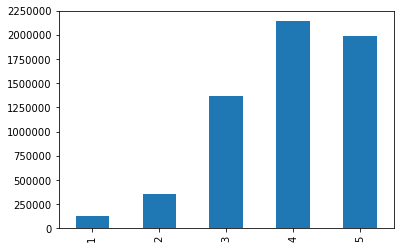

In [21]:
ratings["rating"].value_counts().sort_index().plot(kind="bar");

Let's also see how many users have rated `N` books, for all `N` possible

To do this we will use `value_counts` twice (can you think of why?)

We will see a more flexible way of doing grouped operations like this in a future module

In [22]:
users_by_n = (ratings["user_id"]
              .value_counts()  # Series. Index: user_id, value: n ratings by user
              .value_counts()  # Series. Index: n_ratings by user, value: N_users with this many ratings
              .sort_index()    # Sort our Series by the index (number of ratings)
              .reset_index()   # Dataframe with columns `index` (from above) and `user_id`
              .rename(columns={"index": "N_ratings", "user_id": "N_users"})
             )
users_by_n.head(10)

N_ratings  N_users
0         19        1
1         20        1
2         21        3
3         22       13
4         23        5
5         24       11
6         25       13
7         26       23
8         27       34
9         28       26

Let's look at some statistics on that data set

In [23]:
users_by_n.describe()

N_ratings     N_users
count  181.00000  181.000000
mean   109.01105  295.160221
std     52.41342  309.461848
min     19.00000    1.000000
25%     64.00000   40.000000
50%    109.00000  158.000000
75%    154.00000  538.000000
max    200.00000  964.000000

We can see the same data visually in a box plot

N_ratings       Axes(0.125,0.125;0.352273x0.755)
N_users      Axes(0.547727,0.125;0.352273x0.755)
dtype: object

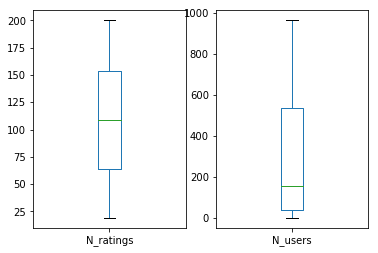

In [24]:
users_by_n.plot(kind="box", subplots=True)

Let's practice applying the want operator...

Let's saw that we *want* to determine if there is a relationship between the number of ratings a user has left and the distribution of the ratings (maybe we are an author hoping to inflate our ratings and wonder if we should target "more experienced" Goodreads users, or focus on newcomers)

Let's start from the result and work our way backwards:

1. We can answer our question if we have two similar DataFrames:
    - All ratings by the `N` (e.g. 5) users with the most ratings 
    - All ratings by the the `N` users with the least number of ratings
2. To get that we will need to extract rows of `ratings` with `user_id` associated with the `N` most and least prolific raters
3. For that we need the most and least active `user_id`s
4. To get that info we need a count of how many ratings each user left
    - We can get that with `df["user_id"].value_counts()`, so let's start there

In [25]:
# step 4
n_ratings = ratings["user_id"].value_counts()
n_ratings.head()

30944    200
12874    200
52036    199
28158    199
12381    199
Name: user_id, dtype: int64

In [26]:
# step 3
N = 5
most_prolific_users = n_ratings.nlargest(5).index.tolist()
least_prolific_users = n_ratings.nsmallest(5).index.tolist()

In [27]:
# step 2
active_ratings = ratings.loc[ratings["user_id"].isin(most_prolific_users), :]
inactive_ratings = ratings.loc[ratings["user_id"].isin(least_prolific_users), :]

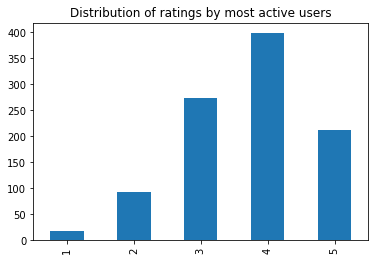

In [28]:
# step 1 -- get the answer!
active_ratings["rating"].value_counts().sort_index().plot(
    kind="bar", title="Distribution of ratings by most active users"
)

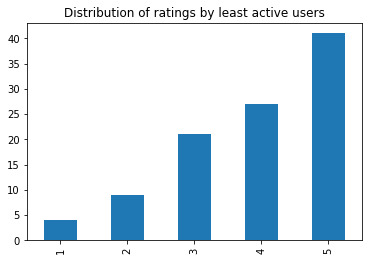

In [29]:
inactive_ratings["rating"].value_counts().sort_index().plot(
    kind="bar", title="Distribution of ratings by least active users"
)

Nice! From the picture above it looks like the new users are much more likely to leave 5 star ratings than the more experienced users

### Book data

I know what you are probably thinking: "Isn't this a lecture on merging? Why are we only using one dataset?"

I hear you

Let's also load up a dataset containing information on the actual books

In [30]:
books = valorum.data.load("goodreads_books")
# we only need a few of the columns
books = books[["book_id", "authors", "title"]]
print("shape: ", books.shape)
print("dtypes:\n", books.dtypes, sep="")
books.head()

shape:  (10000, 3)
dtypes:
book_id     int64
authors    object
title      object
dtype: object


book_id                      authors  \
0        1              Suzanne Collins   
1        2  J.K. Rowling, Mary GrandPré   
2        3              Stephenie Meyer   
3        4                   Harper Lee   
4        5          F. Scott Fitzgerald   

                                               title  
0            The Hunger Games (The Hunger Games, #1)  
1  Harry Potter and the Sorcerer's Stone (Harry P...  
2                            Twilight (Twilight, #1)  
3                              To Kill a Mockingbird  
4                                   The Great Gatsby

We could do similar "interesting" things with just the books dataset, but we will skip it for now and merge them together

**Exercise**: In the cell below, combine the `ratings` and `books` DataFrames using the `pd.merge` function. Save the output in a variable `rated_books`

Make sure the output has the same number of rows as the `ratings` dataset (hint: you will need to think about the `how` argument in connection with what order you pass the two DataFrames to the `pd.merge`)

How long did it take pandas to do the merge? Did that surprise you? Does it impress you??

In [ ]:
%%time

# your code ---- here ↓ !!!
rated_books = pd.merge()


# this tests if you did the merge correctly
if rated_books.shape[0] == ratings.shape[0]:
    print("Well done, merge successful")
else:
    print("Try again... rated_books doesn't have same number of rows as ratings")

Now, let's see which books have been rated the most

In [ ]:
most_rated_books_id = rated_books["book_id"].value_counts().nlargest(10).index
most_rated_books = rated_books.loc[rated_books["book_id"].isin(most_rated_books_id), :]
list(most_rated_books["title"].unique())

Let's use our `pivot_table` knowledge to compute the average rating for each of these books

In [ ]:
most_rated_books.pivot_table(values="rating", index="title")

These ratings seem surprisingly low, given that they are the most often rated books on Goodreads

I wonder what the bottom of the distribution looks like...

**Exercise**: Repeat the analysis above to determine the average rating for the books with the _least_ number
ratings

Is there a distinguishable difference in the average rating compared to the most rated books?

Did you recognize any of the books?

Let's compute the average number of ratings for each book in our sample

In [ ]:
average_ratings = (rated_books
                   .pivot_table(values="rating", index="title")
                   .sort_values(by="rating", ascending=False)
                  )
average_ratings.head(10)

What does the overall distribution of average ratings look like?

In [ ]:
# plot a kernel density estimate of average ratings
average_ratings.plot.density(xlim=(1, 5))

# or a histogram
average_ratings.plot.hist(bins=30, xlim=(1, 5))

It looks like most books have an average rating of just below 4

## Extra Example

In a previous notebook, we saw airline performance data

We could figure out which airlines had the most frequent delays but were left with a 2-3 digit/letter code that we had to look up

Here we merge a DataFrame with carrier codes into our airline performance data

In [32]:
import pandas as pd
import valorum

In [33]:
air_perf = valorum.load("airline_performance_nov16")
carrier_code = valorum.load("airline_carrier_codes")

In [34]:
air_perf.head()

Carrier Tail_Num  Fl_Num  Origin_City_Market_Id Origin Origin_City_Name  \
0      AA   N897AA    1506                  30559    SEA      Seattle, WA   
1      AA   N4XWAA    1507                  30977    ORD      Chicago, IL   
2      AA   N5FMAA    1509                  30721    BOS       Boston, MA   
3      AA   N5FMAA    1509                  32467    MIA        Miami, FL   
4      AA   N3JHAA    1510                  30977    ORD      Chicago, IL   

  Origin_State_Nm  Dest_City_Market_Id Dest   Dest_City_Name    ...      \
0      Washington                32575  LAX  Los Angeles, CA    ...       
1        Illinois                30436  TUS       Tucson, AZ    ...       
2   Massachusetts                32467  MIA        Miami, FL    ...       
3         Florida                30721  BOS       Boston, MA    ...       
4        Illinois                33195  TPA        Tampa, FL    ...       

  Air_Time Distance Carrier_Delay  Weather_Delay  Nas_Delay  Security_Delay  \
0    109.0    954.0          28.0            0.0        0.0             0.0   
1    201.0   1437.0           0.0            0.0        0.0             0.0   
2    191.0   1258.0           0.0            0.0       92.0             0.0   
3    147.0   1258.0           0.0            0.0        0.0             0.0   
4    137.0   1012.0           0.0            0.0        0.0             0.0   

   Late_Aircraft_Delay First_Dep_Time Total_Add_Gtime       Date  
0                 15.0         2040.0            10.0 2016-12-01  
1                  0.0            NaN             NaN 2016-12-01  
2                  0.0            NaN             NaN 2016-12-01  
3                  0.0            NaN             NaN 2016-12-01  
4                  0.0            NaN             NaN 2016-12-01  

[5 rows x 34 columns]

In [35]:
carrier_code.head()

Description
Code                                         
02Q                   Titan Airways (2006 - )
04Q              Tradewind Aviation (2006 - )
05Q         Comlux Aviation, AG (2006 - 2012)
06Q   Master Top Linhas Aereas Ltd. (2007 - )
07Q             Flair Airlines Ltd. (2007 - )

Below we compute the 10 carriers who have the highest mean delay that they are "responsible for causing"

In [36]:
avg_delays = (air_perf
              .pivot_table(index="Carrier", values="Carrier_Delay", aggfunc="mean")
              .sort_values("Carrier_Delay")
              .nlargest(10, "Carrier_Delay"))
avg_delays

Carrier_Delay
Carrier               
F9            7.856566
EV            7.125663
OO            6.705469
B6            5.588006
DL            4.674957
HA            4.577753
UA            4.368148
NK            4.166264
AA            4.073358
VX            3.342923

In order to know who the culprits are, we can merge the carrier codes in using `pd.merge`

Data (and anecdotal data that I can tell you more about another day) tell us that Frontier is often delayed

In [37]:
avg_delays_w_code = pd.merge(avg_delays,
                             carrier_code,
                             left_index=True,
                             right_index=True)

avg_delays_w_code.sort_values("Carrier_Delay", ascending=False)

Carrier_Delay                                Description
F9       7.856566           Frontier Airlines Inc. (1994 - )
EV       7.125663         ExpressJet Airlines Inc. (2012 - )
EV       7.125663  Atlantic Southeast Airlines (1993 - 2011)
OO       6.705469            SkyWest Airlines Inc. (2003 - )
B6       5.588006                  JetBlue Airways (2000 - )
DL       4.674957             Delta Air Lines Inc. (1960 - )
HA       4.577753           Hawaiian Airlines Inc. (1960 - )
UA       4.368148            United Air Lines Inc. (1960 - )
NK       4.166264                 Spirit Air Lines (1992 - )
AA       4.073358           American Airlines Inc. (1960 - )
VX       3.342923                   Virgin America (2007 - )
VX       3.342923                Aces Airlines (1992 - 2003)